# Fundamentals of Computer Science 30398 - Lecture 13

We will continue today implementation of basic algorithms for weighted graphs from the last lecture. As a reminder, we had a basic implementation of a class `WeightedGraph` to store a weighted graph. It has three fields of interest: `n` keeping the number of vertices of a graph, `neighbors` --- a list of size `n`, s.t. `G.neighbors[i]` contains a list of all edges incident with a vertex `i` in a graph. Each edge in such a list is represented by a pair `(target, weight)` where `target` is an index of the of the edge, and `weight` is the weight of the edge.

An implementation of `__init__` method and `add_edge` method follows below.

In [1]:
class WeightedGraph:
    def __init__(self, n):
        self.n = n
        self.neighbors = [ [] for i in range(n) ]
        self.edges = []
        
    def add_edge(self,start_v, target_v, weight):
        self.edges.append( (start_v,target_v, weight) )
        self.neighbors[start_v].append( (target_v, weight))
        self.neighbors[target_v].append( (start_v, weight) )

We can now create a simple weighted graph, like follows:

In [3]:
G = WeightedGraph(5)
G.add_edge(0, 1, 1)
G.add_edge(0, 2, 1)
G.add_edge(2, 1, 5)
G.add_edge(3, 4, 2)
G.add_edge(2, 3, 3)
G.add_edge(1, 4, 10)

Let's inspect its fields:

In [6]:
G.n

5

In [4]:
G.edges

[(0, 1, 1), (0, 2, 1), (2, 1, 5), (3, 4, 2), (2, 3, 3), (1, 4, 10)]

# Minimum Spanning Tree

For the sake of presentation in these notes we will write the Kruskal algorithm for minimum spanning tree first as an function outside the class - this way we can write each function in a seperate cell, and discuss what is going on in between. We will later move those functions to become methods of a class `WeightedGraph`, since this is more reasonable place for them to be.

We will start by implementing Kruskal algorithm as it was discussed informally in the last lecture. We first sort all edges, using Python builtin `sorted`, then iterate over the edges in an order of increasing weight --- if the two colors of the endpoints of an edge are equal, we skip this edge. If they are not: we add the edge to the tree, and recolor all vertices with color `color[a]`, to have `color[b]` now.

Since the function `recolor` by itself is a chunk of logic that we do not want to think about right now, let's just pretend that it is already written: take care of the main part of the algorithm, and write a function `recolor` later on.

In [9]:
def MST(graph):
    sorted_edges = sorted(graph.edges, key = lambda x: x[2])
    color = [ i for i in range(graph.n)]
    result = []
    for edge in sorted_edges:
        a, b, w = edge
        if color[a] == color[b]:
            continue
        recolor(color, color[a], color[b])
        result.append(edge)
    return result

One small comment: the function `sorted` is sorting the entire list of elements, but in our case the elements are triples --- with no obvious way to order it. By itself, the funcion have no way of knowing that we want to sort it according to increasing weight, the third element of each triple. Luckly, if we look at a documentation of a function `sorted`, we see

In [15]:
?sorted

Signature: sorted(iterable, /, *, key=None, reverse=False)
Docstring:
Return a new list containing all items from the iterable in ascending order.

A custom key function can be supplied to customize the sort order, and the
reverse flag can be set to request the result in descending order.
Type:      builtin_function_or_method

It takes a custom `key` function that can be used to customize the sort order --- this function should take an element of a list, and returns the key with respect to which the list should be sorted: in our case, a third  element of a tuple. We create such a function in-line with `lambda x: x[2]` code, and pass it as an argument to the `sorted` function. This is reminiscent of passing the `compare` function to our own implementation of the QuickSort algorithm in one of the previous lectures.

**Exercise**
Now all we need to do is to implement function `recolor`. This is an extremely simple piece of code: it should take three arguments: list `colors`, the `source` color, and the `target` color, and it should modify the original list `colors` --- whenever it encounters color `source` in this list, change its value to `target`.

In [10]:
def recolor(colors, source, target):
    for i in range(len(colors)):
        if colors[i] == source:
            colors[i] = target

Let's try it on a graph $G$ constructed above:

In [12]:
MST(G)

[(0, 1, 1), (0, 2, 1), (3, 4, 2), (2, 3, 3)]

Seems to work! We can move our functions `MST` and `recolor` to become methods in a class `WeightedGraphs` -- let's do it carefully. First of all, the first argument (refering to the object of a class we are implementing method for) is conventionally called `self` --- we should make sure we consistently change all `graph` occurences in the function `MST` to `self`. Moreover, since `recolor` is now a method of a graph class, we will call it as `self.recolor(...)`, and it takes an additional argument `self`.

In [13]:
class WeightedGraph:
    def __init__(self, n):
        self.n = n
        self.neighbors = [ [] for i in range(n) ]
        self.edges = []
        
    def add_edge(self,start_v, target_v, weight):
        self.edges.append( (start_v,target_v, weight) )
        self.neighbors[start_v].append( (target_v, weight))
        self.neighbors[target_v].append( (start_v, weight) )

    def recolor(self, colors, source, target):
        for i in range(len(colors)):
            if colors[i] == source:
                colors[i] = target

    def MST(self):
        sorted_edges = sorted(self.edges, key = lambda x: x[2])
        color = [ i for i in range(self.n)]
        result = []
        for edge in sorted_edges:
            a, b, w = edge
            if color[a] == color[b]:
                continue
            self.recolor(color, color[a], color[b])
            result.append(edge)
        return result

Let's try it!

In [14]:
G = WeightedGraph(5)
G.add_edge(0, 1, 1)
G.add_edge(0, 2, 1)
G.add_edge(2, 1, 5)
G.add_edge(3, 4, 2)
G.add_edge(2, 3, 3)
G.add_edge(1, 4, 10)
G.MST()

[(0, 1, 1), (0, 2, 1), (3, 4, 2), (2, 3, 3)]

# Minnimum Spanning Tree for points on the plane

With this implementation in hand, we would like to compute, and visualize a minimum spanning tree for a collection of random points in the square $[0,1] \times [0,1]$. That is, we will generate `n` random points in a square, and create a complete graph on those `n` points --- the weight of the edge between the two points being the Euclidean distance between them.

For this we will need to import several libraries: `random` to generate random points, `matplotlib.pyplot` for visualization, and `math` to get access to the `sqrt` function, in order to compute distances.

In [17]:
import random
import matplotlib.pyplot as plt
import math

As a reminder, you can use `random.uniform(0,1)` to generate a uniformly random floating point number between $0$ and $1$.

In [18]:
random.uniform(0, 1)

0.5185313465360084

**Exercise**
Write function `random_points(n)` that takes a single number `n` and returns a list of `n` random points in a square: each points both `x` and `y` coordinate should be produced by a call to `random.uniform(0,1)`. Each point on the list is represented by a pair, with `x` and `y` coordinates being respectively the first and second element of the pair.

In [24]:
def random_points(n):
    return [ ( random.uniform(0, 1), random.uniform(0, 1) ) for i in range(n)]

Let's try to generate $n$ random points with this and visualize them, using `plt.scatter` method. As a reminder, the method should take two lists `x` and `y` of equal lenght, `x[i]` and `y[i]` containing the coordinartes of the `i`-th point. Since our own function `random_points` instead returns a single list of pairs, we need to split it into two lists first.

In [51]:
N = 300

In [52]:
points = random_points(N)
xx = [ p[0] for p in points]
yy = [ p[1] for p in points]

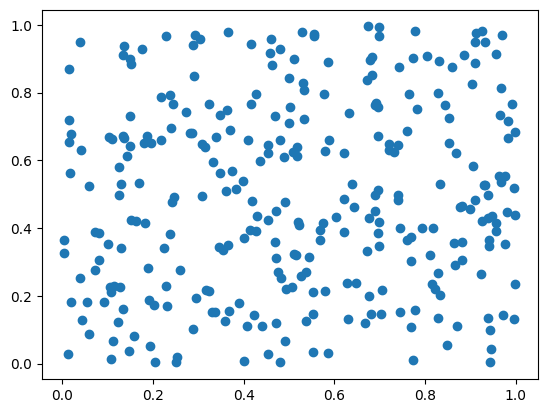

In [53]:
plt.scatter(xx, yy)

**Exercise**
Write a function `distance(p1,p2)` that takes two points `p1` and `p2` (each a pair with two entries), and calculates the Euclidean distance between those two points, i.e. $\sqrt{(p_1[0] - p_2[0])^2 + (p_1[1] - p_2[1])^2}$. You can use `math.sqrt` function to compute a square root.

In [55]:
def distance(p1, p2):
    return math.sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

**Exercise**
Write a function `get_graph_from_pointset(ps)` that takes as an input a list of points `ps` (with the same format as a list returned by `random_points`), and returns a `WeightedGraph` with a vertex for every point in `ps`. The returned graph should be a complete graph (each point is connected to each other), with a weight of an edge given by Euclidean distance between the corrsponding points on a plane (computed by `distance` function you just wrote)

In [56]:
def get_graph_from_pointset(ps):
    result = WeightedGraph(len(ps))
    for i in range(len(ps)):
        for j in range(i):
            result.add_edge(i, j, distance(ps[i], ps[j]))
    return result

We can now get a graph from a pointset, and calculate a minimum spanning tree for this set of points on a plane, using the `MST` function we already wrote.

In [57]:
G = get_graph_from_pointset(points)

In [58]:
mst = G.MST()

Let's inspect it:

In [59]:
len(mst)

299

In [60]:
mst[:10]

[(73, 67, 0.003662751457386217),
 (245, 34, 0.004456779472087372),
 (217, 141, 0.004679820890852126),
 (299, 291, 0.005588141645957734),
 (207, 29, 0.0056199091992866065),
 (279, 52, 0.005793361977837254),
 (294, 86, 0.006265322832906619),
 (261, 160, 0.00702833643103612),
 (221, 137, 0.007037095502405815),
 (279, 273, 0.007689760241359709)]

It's unclear if it's working just yet, but at least it's returning the right number of edges, and the format seems reasonable.

Let's try to visualize the returned edges on a plot

In [61]:
def draw_edges(edges_list, ps):
    for a,b,w in edges_list:
        plt.plot([ps[a][0], ps[b][0]], [ps[a][1], ps[b][1]])

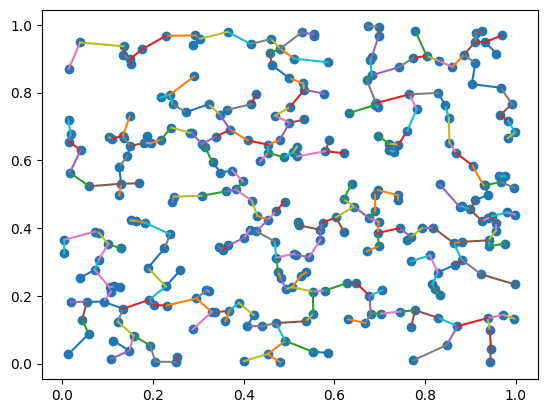

In [62]:
plt.scatter(xx, yy)
draw_edges(mst, points)

The tree looks reasonable, but maybe the visualization is a bit too colorful for ones taste. As it turns out function `plot` takes an additional argument `color`, so we can make all the edges of the same color.

In [63]:
def draw_edges(edges_list, ps, color="red"):
    for a,b,w in edges_list:
        plt.plot([ps[a][0], ps[b][0]], [ps[a][1], ps[b][1]], color=color)

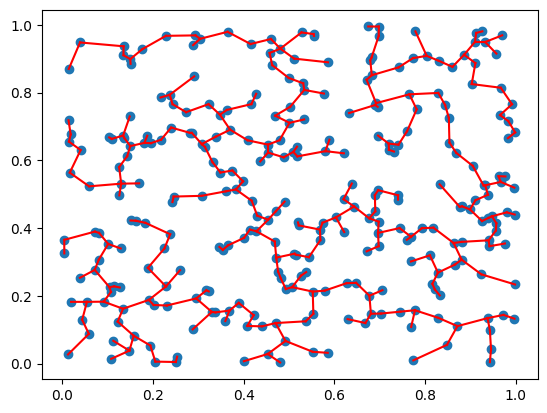

In [64]:
plt.scatter(xx, yy)
draw_edges(mst, points)

### A threshold graph

**Exercise**

Write a function `get_threshold_graph(ps, threshold)` that takes a pointset, and a `threshold`. It should return a `WeightedGraph` in which we connect two points only if the distance between them is smaller than `threshold` (and the weight of the corresponding edge is equal to the distacne).

**Solution.**

In [65]:
def get_threshold_graph(ps, threshold):
    result = WeightedGraph(len(ps))
    for i in range(len(ps)):
        for j in range(i):
            d = distance(ps[i], ps[j])
            if d < threshold:
                result.add_edge(i, j, d)
    return result

We can try to visualize such a graph:

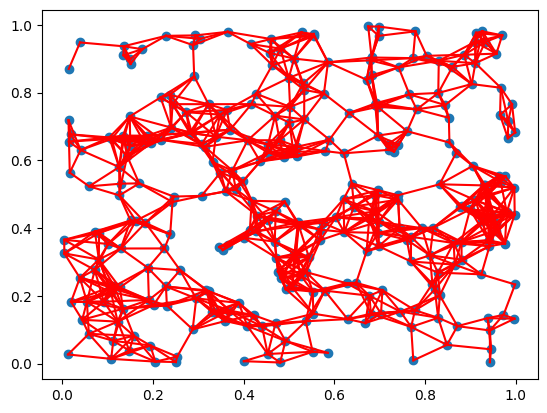

In [66]:
Gt = get_threshold_graph(points, 0.1)
draw_edges(Gt.edges, points)
plt.scatter(xx, yy)

That's probably a bit too messy. As it turns out, the parameter `color` can be either an english name of a `color` (as before `"red"`), or a quadruple `(r,g,b,a)` of four numbers between `0` and `1`. The first four numbers specify the amount of red, blue and green in the color, the third `a` (from "alpha") the transparency: `0` is completely transparent, `1` is complete opaque.

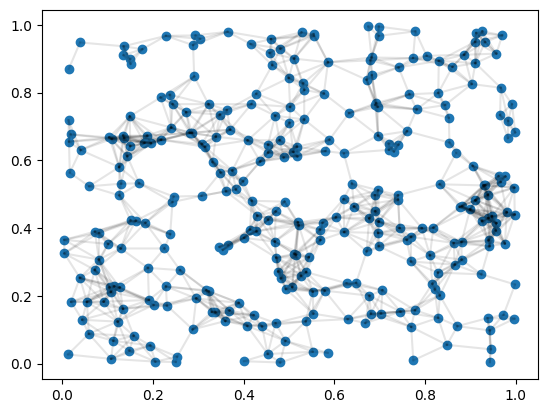

In [67]:
Gt = get_threshold_graph(points, 0.1)
draw_edges(Gt.edges, points, color=(0,0,0,0.1))
plt.scatter(xx, yy)

We can draw a MST on top of the graph:

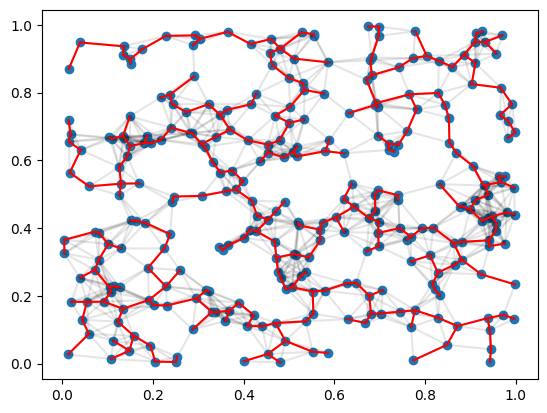

In [68]:
Gt = get_threshold_graph(points, 0.1)
mst = Gt.MST()
plt.scatter(xx, yy)
draw_edges(Gt.edges, points, color = (0,0,0,0.1) )
draw_edges(mst, points, color="red")

The neat part is that the edges returned by `WeightedGraph.MST` method are given in the order they were added to the graph. We can visualize how the MST grows when constructed by Kruskal algorithm, by drawing only the first $k$ edges in the MST.

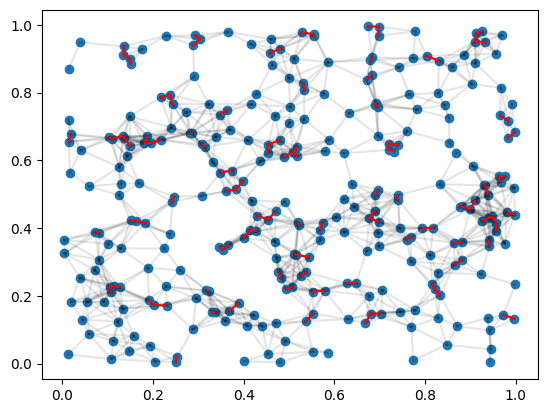

In [79]:
Gt = get_threshold_graph(points, 0.1)
mst = Gt.MST()
plt.scatter(xx, yy)
draw_edges(Gt.edges, points, color = (0,0,0,0.1) )
draw_edges(mst[:100], points, color="red")

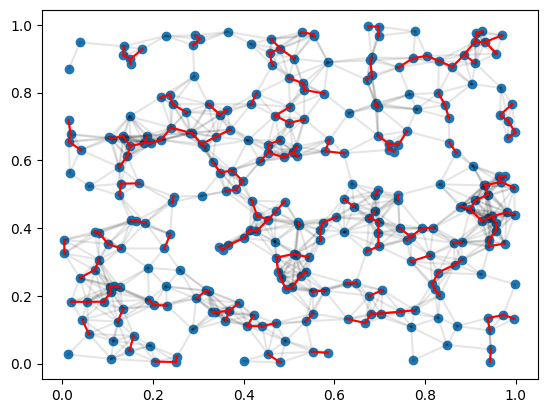

In [80]:
Gt = get_threshold_graph(points, 0.1)
mst = Gt.MST()
plt.scatter(xx, yy)
draw_edges(Gt.edges, points, color = (0,0,0,0.1) )
draw_edges(mst[:200], points, color="red")

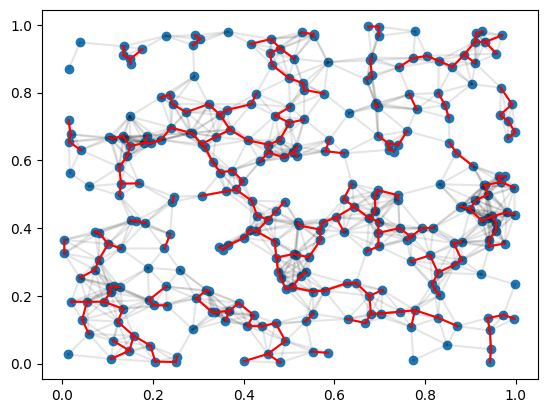

In [81]:
Gt = get_threshold_graph(points, 0.1)
mst = Gt.MST()
plt.scatter(xx, yy)
draw_edges(Gt.edges, points, color = (0,0,0,0.1) )
draw_edges(mst[:250], points, color="red")

### Faster implementation of the Kruskal algorithm

Note that we discussed in course that minimum spanning tree can be computed in time $O(m \log m)$. The implementation we provided at beginning of the course runs in time $\Theta(m \log m + n^2)$ --- for $m \approx n$ this is much slower.

What is the issue? We sort all the edges in time $O(m \log m)$ but then, as we iterate over all edges, whenever we find a new edge that should be added to the MST (which happens $n-1$ times), we call a function `recolor` which iterates over all possible vertices in $\Theta(n)$ time, leading to the final runtime of $\Theta(n^2)$.

It's easy to come up with a simple improvement. If we maitained not only a list `color` of a color of each node, but also a reverse list: `color_class`, s.t. `color_class[k]` contains indices of all vertices of color `k` we could implement the function `recolor` slightly better: instead of iterating only over all vertices of a graph, we could only iterate over all vertices of the source color, and change their colors.

We need to remember that `recolor` function should appropriately update now both lists: `color` and `color_class`.

In [71]:
def recolor(color, color_class, source, target):
    # iterate over all vertices with color `source`
    for v in color_class[source]:
        # for each vertex change its color to `target
        color[v] = target
        # and append it to a list of vertices with color `target`
        color_class[target].append(v)
    # there is no vertex with color `source` anymore
    color_class[source] = []

In [72]:
def MST(graph):
    sorted_edges = sorted(graph.edges, key = lambda x: x[2])
    color = [ i for i in range(graph.n)]
    color_class = [ [i] for i in range(graph.n)]
    result = []
    for edge in sorted_edges:
        a, b, w = edge
        if color[a] == color[b]:
            continue
        recolor(color, color_class, color[a], color[b])
        result.append(edge)
    return result

This might work much faster in certain situations, but in the worst case we didn't gain much: this still runs in time $\Omega(n^2)$ (think of a graph that happens to be a long path with increasing weights of each edge; in each stage we might recolor all vertices previously colored). 

This bad example suggests a subsequent improvement: once we see an edge $(a, b)$ we can choose to recolor all vertices with color `color[a]` to `color[b]`, or the other way around. Which should we choose? Clearly let's recollor the smaller color class:

In [73]:
def MST(graph):
    sorted_edges = sorted(graph.edges, key = lambda x: x[2])
    color = [ i for i in range(graph.n)]
    color_class = [ [i] for i in range(graph.n)]
    result = []
    for edge in sorted_edges:
        a, b, w = edge
        if color[a] == color[b]:
            continue
        if len(color_class[color[a]]) < len(color_class[color[b]]):
            recolor(color, color_class, color[a], color[b])
        else:
            recolor(color, color_class, color[b], color[a])
        result.append(edge)
    return result

Let's make sure that our new implementation still works - it should return the exact same MST as the previous one (except faster):

In [74]:
MST(Gt) == Gt.MST()

True

### Complexity discussion
As it turns out the last improvement wasn't just a "clever hack" in fact it did improve worst-case complexity of an implemented algorithm from $\Theta(m \log m + n^2)$ to $\Theta(m \log m + n \log n) = \Theta(m \log m)$.

Clearly the sorting phase still takes time $\Theta(m \log m)$. Let us argue that the second phase at most $O(n \log n)$ time.

It is a priori unclear: again we call the function `recolor` $n-1$ times, and each of those calls, in the worst case, takes $O(n)$ time. We would like to argue that in fact, the total time we spend in all functions `recolor` is at most $O(n \log n)$. Observe that the total time we spend in the function `recolor` is proportional to the total number of times all vertices changed their color. Instead of arguing directly that most of the phases didn't recolor too many vertices, we can focus on how many times each vertex changed their own color, and sum this up over all vertices.

**Fact**
Each vertex changed their color at most $\log_2 n$ times.

_Proof._
Since we always recollor a smaller color class, every time a vertex is recolored, it's color class size must have grown at least by a factor of $2$. After $k$ recoloring, it must be in a color class of size at least $2^k$, and since there are only $n$ vertices, it couldn't have changed color more than $\log_2 n$ times.

**Colorally**
The total running time of the second phase of the algorithm (after sorting) is $O(n \log n + m)$. 
_Proof_
The total running time of all `recolor` calls is $O(n \log n)$ --- we have $n$ vertices, each changes its color at most $\log_2 n$ times. Iterating over all additional edges (which are not included in the tree) takes $O(m)$ time.

### Updated WeightedGraph class

Let's update the weighted graph class, by including the new, faster MST function.

In [76]:
class WeightedGraph:
    def __init__(self, n):
        self.n = n
        self.neighbors = [ [] for i in range(n) ]
        self.edges = []
        
    def add_edge(self,start_v, target_v, weight):
        self.edges.append( (start_v,target_v, weight) )
        self.neighbors[start_v].append( (target_v, weight))
        self.neighbors[target_v].append( (start_v, weight) )

    def recolor(self, color, color_class, source, target):
        for v in color_class[source]:
            color[v] = target
            color_class[target].append(v)
        color_class[source] = []

    def MST(self):
        sorted_edges = sorted(self.edges, key = lambda x: x[2])
        color = [ i for i in range(self.n)]
        color_class = [ [i] for i in range(self.n)]
        result = []
        for edge in sorted_edges:
            a, b, w = edge
            if color[a] == color[b]:
                continue
            if len(color_class[color[a]]) < len(color_class[color[b]]):
                self.recolor(color, color_class, color[a], color[b])
            else:
                self.recolor(color, color_class, color[b], color[a])
            result.append(edge)
        return result

Let's see if it still works:

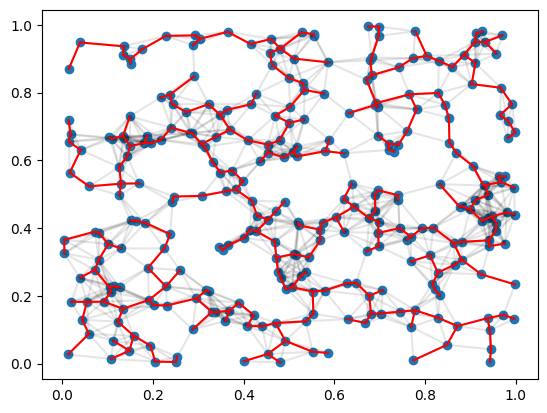

In [78]:
Gt = get_threshold_graph(points, 0.1)
mst = Gt.MST()
plt.scatter(xx, yy)
draw_edges(Gt.edges, points, color = (0,0,0,0.1) )
draw_edges(mst, points, color="red")

## Dijsktra's algorithm for shortest paths

We will now try to implement the Dijkstra's algorithm that was discussed in a class before. The main tool used in the description of the algorithm is a "Priority Queue" --- we need a data structure to which we can insert elements together with their "priority" (for us, it will be the currently comptued distance from the source), and take out an element with the lowest priority so far. It is not terribly difficult to implement such a data structure using "Heap", but we won't discuss the details of it on this course. Instead, we will use an implementation already provided to us in the python builtin library:

In [82]:
import queue

We can create a new Priority Queue

In [83]:
pq = queue.PriorityQueue()

We care about three relevant methods of the `PriorityQueue` class. We can check if the queue is empty:

In [84]:
pq.empty()

True

We can add some elements with the corresponding priority

In [88]:
pq.put( (5, "John") )
pq.put( (7, "Jim") )
pq.put( (2, "Jane") ) 

In [89]:
pq.empty()

False

And we can get an element with the lowest priority (while removing it from the queue):

In [90]:
pq.get()

(2, 'Jane')

In [91]:
pq.get()

(5, 'John')

In [92]:
pq.put( (3, "Jackie") )

In [93]:
pq.get()

(3, 'Jackie')

In [94]:
pq.get()

(5, 'John')

In [95]:
pq.empty()

False

Importantly, both `put` and `get` functions run in time $O(\log n)$ in worst case.

With this data structure in hand, we can almost directly implement the Dijkstra algorithm as it was described during the lecture. The first five lines are just initialization of relevant structures: we need an array that keeps for us shortest distances computed from the source so far (initially all distances are $\infty$, except of `source` for which it has distacne $0$), and an array `visited` which keeps track of whether a given vertex was already processed.

In each stage, as long as the priority queue is not empty, we take the vertex with a smallest distance from the queue. If this vertex was already processed - we skip it. Otherwise, we iterate over all the edges, and update the shortest distance of the neighbors of `v` if necessary: i.e. if we can find a shorter path from source to `v` through `t` than the previously seen, we update `distance` and put the new pair `(distance[t], t)` into the priority queue.

Note that this way, the same vertex might be in the priority queue multiple times at once, with different distances. This is not an issue: after we have taken it once from the queue and processed, we set the flag `visited` to `True`. Any time in the future we pick up this vertex (with some larger distance, as it was inserted earlier in the ccourse of algorithm), we will skip processing it.

In [98]:
def Dijkstra(graph, source):
    distances = [ float("inf") for i in range(graph.n)]
    distances[source] = 0
    visited = [ False for i in range(graph.n)]
    pq = queue.PriorityQueue()
    pq.put( (0, source) )

    while not pq.empty():
        dist, v = pq.get()
        if visited[v]:
            continue
        visited[v] = True
        for t, weight in graph.neighbors[v]:
            if distances[t] > distances[v] + weight:
                distances[t] = distances[v] + weight
                pq.put( (distances[t], t))
    return distances

Let's put it as a method in the class `WeightedGraph` we are writing:

In [103]:
class WeightedGraph:
    def __init__(self, n):
        self.n = n
        self.neighbors = [ [] for i in range(n) ]
        self.edges = []
        
    def add_edge(self,start_v, target_v, weight):
        self.edges.append( (start_v,target_v, weight) )
        self.neighbors[start_v].append( (target_v, weight))
        self.neighbors[target_v].append( (start_v, weight) )

    def recolor(self, color, color_class, source, target):
        for v in color_class[source]:
            color[v] = target
            color_class[target].append(v)
        color_class[source] = []

    def MST(self):
        sorted_edges = sorted(self.edges, key = lambda x: x[2])
        color = [ i for i in range(self.n)]
        color_class = [ [i] for i in range(self.n)]
        result = []
        for edge in sorted_edges:
            a, b, w = edge
            if color[a] == color[b]:
                continue
            if len(color_class[color[a]]) < len(color_class[color[b]]):
                self.recolor(color, color_class, color[a], color[b])
            else:
                self.recolor(color, color_class, color[b], color[a])
            result.append(edge)
        return result
        
    def Dijkstra(self, source):
        distances = [ float("inf") for i in range(self.n)]
        distances[source] = 0
        visited = [ False for i in range(self.n)]
        pq = queue.PriorityQueue()
        pq.put( (0, source) )
    
        while not pq.empty():
            dist, v = pq.get()
            if visited[v]:
                continue
            visited[v] = True
            for t, weight in self.neighbors[v]:
                if distances[t] > distances[v] + weight:
                    distances[t] = distances[v] + weight
                    pq.put( (distances[t], t))
        return distances
        

In [105]:
Gt = get_threshold_graph(points, 0.1)
Gt.Dijkstra(0)

[0,
 0.9112485965796927,
 1.3707349058560623,
 0.954400693727564,
 0.9796055085519211,
 0.6953804061535469,
 1.2424405606504403,
 0.556412341028004,
 0.8235602847892722,
 0.8016288555060755,
 0.649554647123717,
 0.7205808024961304,
 0.6657290150523545,
 1.2876237428749502,
 0.9510929828921941,
 0.6679009102736135,
 0.5619815644819732,
 0.9358039485602683,
 0.8610120019281216,
 0.971389069558509,
 0.6476514246833037,
 1.122280262537734,
 0.9082308093901474,
 0.43172567741204293,
 1.180168548240251,
 1.001496129584343,
 1.415703806530971,
 0.9908398568675536,
 0.5018636277615762,
 0.5811057805007027,
 0.33075706509162234,
 0.5450060133623142,
 1.16690630106337,
 1.0675296749919825,
 0.8581454697308936,
 1.094064142135936,
 0.9867839531729736,
 0.4196832004778392,
 0.77881366524861,
 1.2351557990639725,
 0.7840385422544435,
 0.5983898530054231,
 1.0185262298435993,
 0.9326022340758809,
 0.7844261288603788,
 0.619830187931652,
 0.9109151537487923,
 0.7192856825877633,
 0.7863338142221369,


**Exercise**

Modify the `Dijkstra` method such that it not only returns the distances, but also the array `prev_vertex`, where for each $v \not= \mathrm{source}$, `prev_vertex[v]` denotes a previous vertex on a shortest path from `source` to `v`. Use this to visualize the shortest path tree.